In [1]:
MODEL_CLS = "cfnet"
PATH_WORK_DIR = "../.."
PATH_CONFIG_DIR = f"./config/{MODEL_CLS}/"

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(PATH_WORK_DIR)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\REPO\PAPER REVIEW\RECSYS\02_MLP\03_RS-DeepCF


# Config

In [4]:
import pandas as pd
import DeepCF
from EXPERIMENT import UTILS
from EXPERIMENT.PIPELINE.builder import pipeline_builder
from EXPERIMENT.TRAINER.builder import trainer_builder
from EXPERIMENT.EVALUATOR.evaluator import Evaluator

In [5]:
from EXPERIMENT.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
)

In [6]:
cfg = UTILS.config.load_yaml(PATH_CONFIG_DIR)

In [7]:
SEED = cfg["runtime"]["seed"]
STRATEGY = cfg["task"]["strategy"]
DATASET = cfg["data"]["name"]
NUM_USERS = cfg["data"]["entity"]["num_users"]
NUM_ITEMS = cfg["data"]["entity"]["num_items"]

In [8]:
UTILS.seed.reset(SEED)

ALL SEEDS RESET: 42


# Data Preparation

In [9]:
df = pd.read_csv(f"./_data/{DATASET}.csv")

In [10]:
UTILS.datahandler.description(df)

number of user: 609
number of item: 8452
total interaction: 81763
interaction density: 1.5885 %
max interaction of user: 2117
max interaction of item: 315
top 10.0 % interaction of user: 344.4
top 10.0 % interaction of item: 25.0
mean interaction of user: 134
mean interaction of item: 9


In [11]:
kwargs = dict(
    df=df,
    cfg=cfg["pipeline"],
    strategy=STRATEGY,
    seed=SEED,
)

dataloaders, interactions, histories = pipeline_builder(**kwargs)

# Modeling

In [12]:
kwargs = dict(
    interactions=interactions,
    num_users=NUM_USERS,
    num_items=NUM_ITEMS,
    **cfg["model"]["rlnet"],
)    

rlnet_module = DeepCF.rlnet.Module(**kwargs)

In [13]:
kwargs = dict(
    interactions=interactions,
    num_users=NUM_USERS,
    num_items=NUM_ITEMS,
    **cfg["model"]["mlnet"],
)    

mlnet_module = DeepCF.mlnet.Module(**kwargs)

In [14]:
kwargs = dict(
    rlnet=rlnet_module,
    mlnet=mlnet_module,
)    

model = DeepCF.cfnet.Module(**kwargs)

# Train

In [15]:
kwargs = dict(
    model=model,
    cfg=cfg["trainer"],
    strategy=STRATEGY,
)

trainer = trainer_builder(**kwargs)

In [16]:
kwargs = dict(
    trn_loader=dataloaders["trn"],
    val_loader=dataloaders["val"],
    dev_loader=dataloaders["dev"],
)

history = trainer.fit(**kwargs)

DEVELOPMENT
	BEST SCORE: 0.5699
	BEST EPOCH: 15


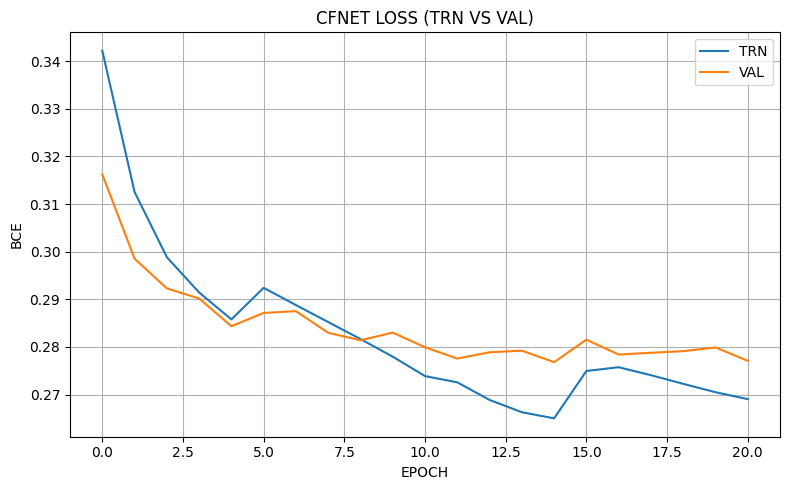

In [17]:
kwargs = dict(
    histories=[history["trn"], history["val"]],
    labels=["TRN", "VAL"],
    criterion="BCE",
    title="CFNET LOSS (TRN VS VAL)"
)

UTILS.visualizer.comparison_curve(**kwargs)

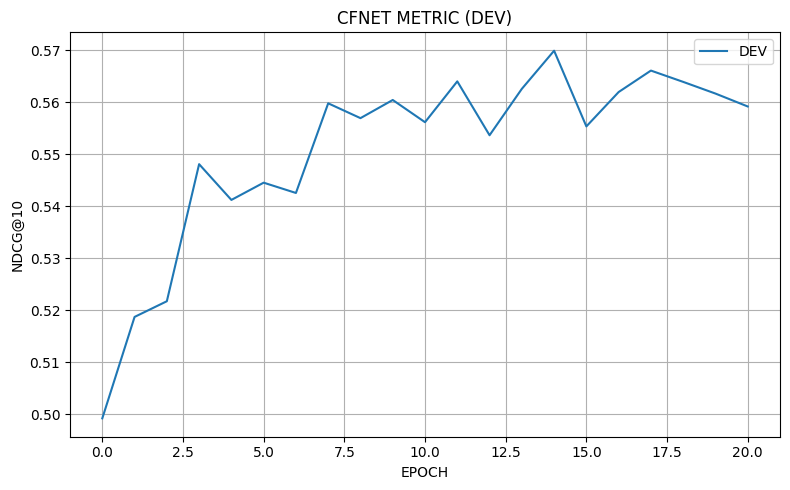

In [18]:
kwargs = dict(
    history=history["dev"],
    label="DEV",
    criterion="NDCG@10",
    title="CFNET METRIC (DEV)",
)

UTILS.visualizer.criterion_curve(**kwargs)

# Test

In [19]:
evaluator = Evaluator(model)

In [20]:
result = evaluator.predict(dataloaders["tst"])

TST: 100%|██████████| 6343/6343 [00:14<00:00, 436.50it/s]


In [21]:
metrics_sheet = evaluator.metrics(result, [5, 10, 15, 20, 25, 50])

In [22]:
metrics_sheet

,k,hit_ratio,precision,recall,map,ndcg
0,5,0.850329,0.380263,0.335142,0.248856,0.471079
1,10,0.932566,0.289474,0.466970,0.300985,0.487944
2,15,0.972039,0.239254,0.547993,0.323219,0.505283
3,20,0.983553,0.205592,0.594513,0.334724,0.516277
4,25,0.993421,0.182632,0.637468,0.343213,0.527907
5,50,0.998355,0.119671,0.734737,0.360541,0.557155


# Save

In [23]:
PATH = f'./_checkpoints/{STRATEGY}/{MODEL_CLS}_{DATASET}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save_model(**kwargs)